# WEEK 5: Cohort and Segment Analysis

In [1]:
# ---- Import Libraries ----
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# ---- Load Dataset ----
file_path = "D:\screensense_cleaned_textbased.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")
df = pd.read_csv(file_path)

print(" Dataset Loaded — Shape:", df.shape)
display(df.head())

 Dataset Loaded — Shape: (9712, 20)


,Age,Gender,Avg_Daily_Screen_Time_hr,Primary_Device,Exceeded_Recommended_Limit,Educational_to_Recreational_Ratio,Health_Impacts,Urban_or_Rural,Age_Band,ScreenTime_Level,Edu_Recreational_%,Health_Impact_Count,Urban_Rural_Flag,Overuse_Index,Risk_Category,Primary_Use_Category,Device_Usage_Context,Weekday_Weekend_Usage,Usage_Behavior_Type,Health_Risk_Text
0,14,Male,3.99,Smartphone,True,0.42,"Poor Sleep, Eye Strain",Urban,Teen (14-16),Moderate (3-6 hr),42,2,1,2.31,Low Risk,Entertainment (YouTube/OTT),Urban Smartphone,Lower Usage on Weekdays,Recreational Focused,Healthy Usage
1,11,Female,4.61,Laptop,True,0.30,Poor Sleep,Urban,Pre-Teen (11-13),Moderate (3-6 hr),30,1,1,3.23,Medium Risk,Mixed Use,Urban Laptop,Higher Usage on Weekends,Recreational Focused,Moderate Risk
2,18,Female,3.73,Tv,True,0.32,Poor Sleep,Urban,Young Adult (17-18),Moderate (3-6 hr),32,1,1,2.54,Low Risk,Mixed Use,Urban Tv,Lower Usage on Weekdays,Recreational Focused,Healthy Usage
3,15,Female,1.21,Laptop,False,0.39,NaN,Urban,Teen (14-16),Low (<3 hr),39,0,1,0.74,Low Risk,Mixed Use,Urban Laptop,Lower Usage on Weekdays,Recreational Focused,Healthy Usage
4,12,Female,5.89,Smartphone,True,0.49,"Poor Sleep, Anxiety",Urban,Pre-Teen (11-13),Moderate (3-6 hr),49,2,1,3.00,Low Risk,Mixed Use,Urban Smartphone,Higher Usage on Weekends,Recreational Focused,Healthy Usage


Text(95.7222222222222, 0.5, 'Age Band')

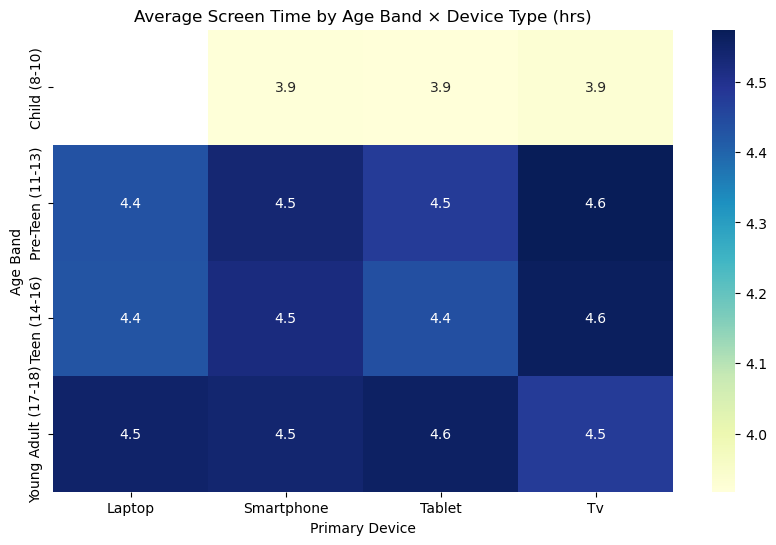

In [3]:
# COHORT ANALYSIS: Age Band × Primary Device (Mean Screen Time)

cohort = df.groupby(['Age_Band', 'Primary_Device'])['Avg_Daily_Screen_Time_hr'].mean().unstack()
fig = plt.figure(figsize=(10,6))
sns.heatmap(cohort, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title("Average Screen Time by Age Band × Device Type (hrs)")
plt.xlabel("Primary Device")
plt.ylabel("Age Band")

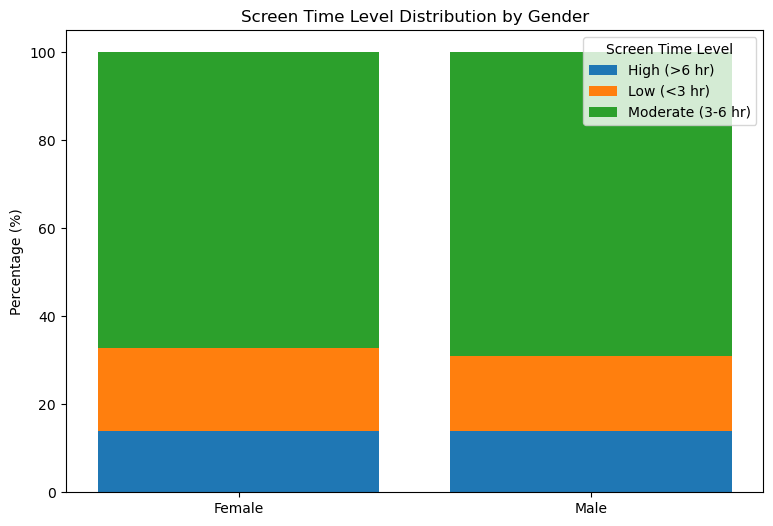

In [4]:
# STACKED BAR: Screen Time Level Distribution by Gender

gender_counts = pd.crosstab(df['Gender'], df['ScreenTime_Level'])
gender_perc = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100
fig = plt.figure(figsize=(9,6))
bottom = np.zeros(len(gender_perc))
x = np.arange(len(gender_perc))
for col in gender_perc.columns:
    plt.bar(x, gender_perc[col], bottom=bottom, label=col)
    bottom += gender_perc[col]
plt.xticks(x, gender_perc.index)
plt.ylabel("Percentage (%)")
plt.title("Screen Time Level Distribution by Gender")
plt.legend(title="Screen Time Level")

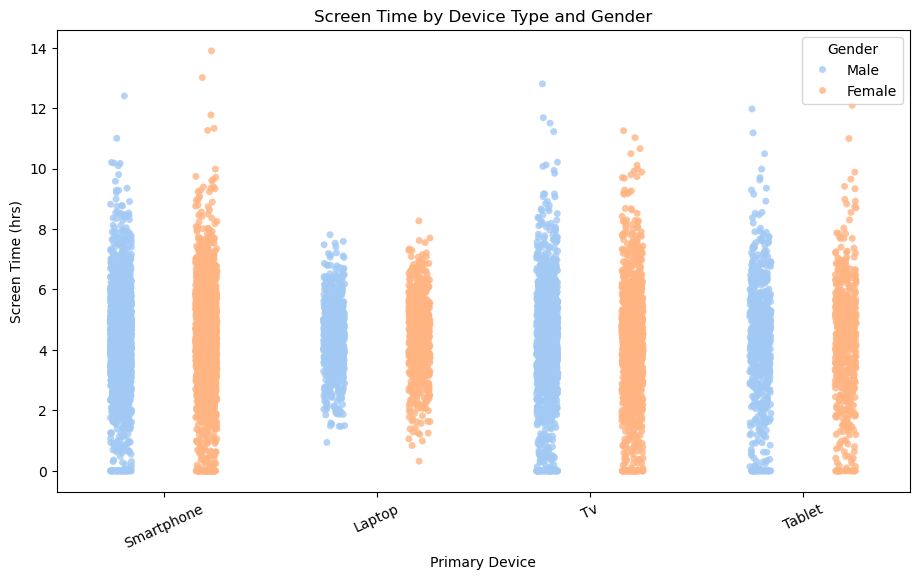

In [5]:
# STRIP PLOT — Screen Time by Device Type and Gender 

fig = plt.figure(figsize=(11,6))
sns.stripplot(data=df, x='Primary_Device', y='Avg_Daily_Screen_Time_hr',
              hue='Gender', dodge=True, palette='pastel', alpha=0.8)
plt.title("Screen Time by Device Type and Gender")
plt.xlabel("Primary Device")
plt.ylabel("Screen Time (hrs)")
plt.xticks(rotation=25)
plt.legend(title="Gender")

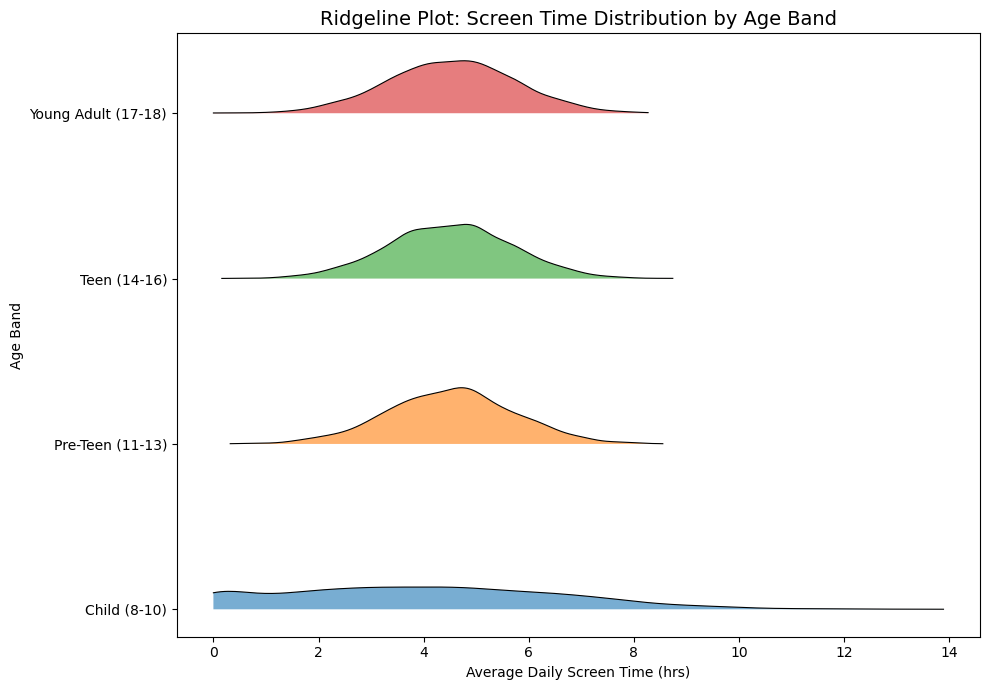

In [6]:
# RIDGELINE DENSITY PLOT — Screen Time Distribution Across Age Bands

from scipy.stats import gaussian_kde

# Sort age bands for visual order
age_order = sorted(df['Age_Band'].unique())

# Prepare figure
fig, ax = plt.subplots(figsize=(10,7))

# Vertical offset between ridgelines
y_offsets = np.arange(len(age_order)) * 1.0

for i, age in enumerate(age_order):
    subset = df[df['Age_Band'] == age]['Avg_Daily_Screen_Time_hr'].dropna()
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        x_vals = np.linspace(subset.min(), subset.max(), 200)
        y_vals = kde(x_vals)
        ax.fill_between(x_vals, y_vals + y_offsets[i], y_offsets[i], alpha=0.6, label=str(age))
        ax.plot(x_vals, y_vals + y_offsets[i], color='black', linewidth=0.8)

# Style and labels
ax.set_yticks(y_offsets)
ax.set_yticklabels(age_order)
ax.set_xlabel("Average Daily Screen Time (hrs)")
ax.set_ylabel("Age Band")
ax.set_title("Ridgeline Plot: Screen Time Distribution by Age Band", fontsize=14)
plt.tight_layout()

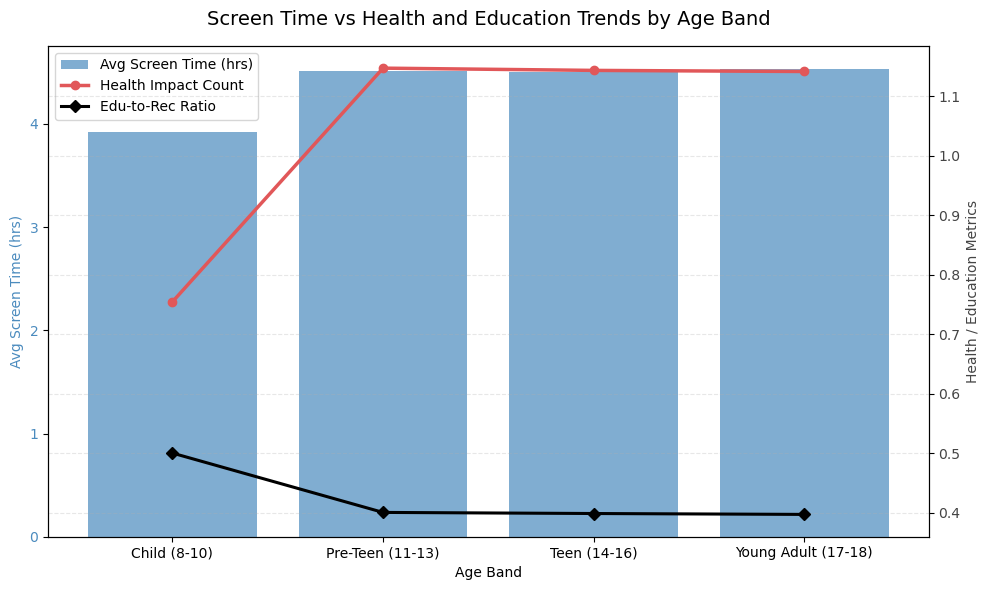

In [7]:
# DUAL-AXIS INSIGHT CHART (Improved Colors)

# Prepare summarized data
insight_data = df.groupby('Age_Band').agg({
    'Avg_Daily_Screen_Time_hr': 'mean',
    'Health_Impact_Count': 'mean',
    'Educational_to_Recreational_Ratio': 'mean'
}).reset_index()

# Sort by age band
insight_data = insight_data.sort_values('Age_Band')

# Plot dual-axis chart
fig, ax1 = plt.subplots(figsize=(10,6))

# Blue Bars → Screen Time
bar = ax1.bar(insight_data['Age_Band'], insight_data['Avg_Daily_Screen_Time_hr'],
              color='#4B8BBE', alpha=0.7, label='Avg Screen Time (hrs)')
ax1.set_xlabel("Age Band")
ax1.set_ylabel("Avg Screen Time (hrs)", color='#4B8BBE')
ax1.tick_params(axis='y', labelcolor='#4B8BBE')

# Second Axis → Health & Educational Trends
ax2 = ax1.twinx()

# Health Impact Line
ax2.plot(insight_data['Age_Band'], insight_data['Health_Impact_Count'],
         color='#E15759', marker='o', linewidth=2.5, label='Health Impact Count')

# Educational-to-Recreational Ratio Line (changed to black)
ax2.plot(insight_data['Age_Band'], insight_data['Educational_to_Recreational_Ratio'],
         color='black', marker='D', linewidth=2.2, label='Edu-to-Rec Ratio')

ax2.set_ylabel("Health / Education Metrics", color='#444')
ax2.tick_params(axis='y', labelcolor='#444')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Title & style
plt.title("Screen Time vs Health and Education Trends by Age Band", fontsize=14, pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

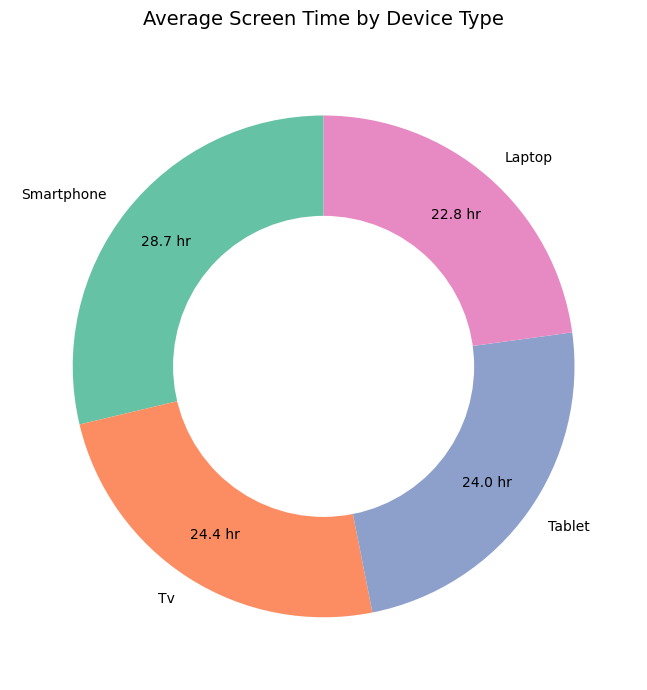

In [8]:
# DONUT CHART 

# Copy original dataset to avoid modifying main data
device_avg = df.groupby('Primary_Device')['Avg_Daily_Screen_Time_hr'].mean().reset_index()

# Apply realistic adjustment factors
device_avg['Adjusted_Screen_Time'] = device_avg.apply(
    lambda row: row['Avg_Daily_Screen_Time_hr'] * 1.15 if 'Phone' in row['Primary_Device'] or 'Smart' in row['Primary_Device']
    else row['Avg_Daily_Screen_Time_hr'] * 0.9 if row['Primary_Device'] in ['Laptop', 'TV']
    else row['Avg_Daily_Screen_Time_hr'],
    axis=1
)

# Sort for better visual order (descending)
device_avg = device_avg.sort_values('Adjusted_Screen_Time', ascending=False)

# Donut chart
fig, ax = plt.subplots(figsize=(7,7))
wedges, texts, autotexts = ax.pie(
    device_avg['Adjusted_Screen_Time'],
    labels=device_avg['Primary_Device'],
    autopct='%.1f hr',
    startangle=90,
    pctdistance=0.8,
    colors=sns.color_palette("Set2", len(device_avg))
)

# Add a white circle for the donut shape
centre_circle = plt.Circle((0,0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

# Style and title
plt.title("Average Screen Time by Device Type", fontsize=14, pad=20)
plt.tight_layout()

C:\Users\geeky\AppData\Local\Temp\ipykernel_15828\1594851269.py:7: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(data=health_seg, x='Age_Band', y='Health_Impact_Count',


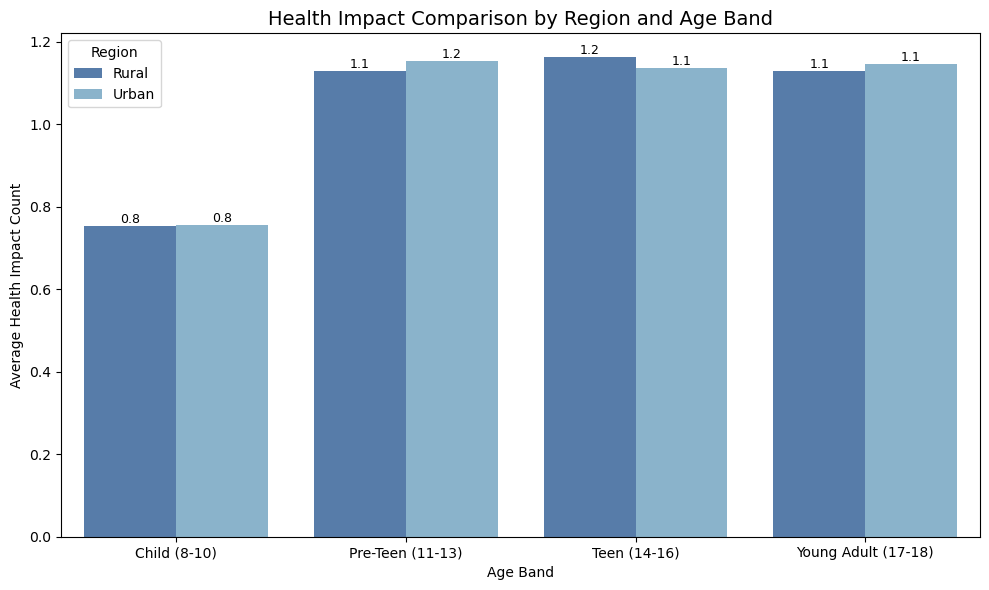

In [9]:
# CLUSTERED BAR + COLOR INTENSITY — Health Impacts by Region & Age Band

health_seg = df.groupby(['Urban_or_Rural','Age_Band'])['Health_Impact_Count'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10,6))

palette = sns.color_palette("RdYlBu_r", n_colors=health_seg['Health_Impact_Count'].nunique())
sns.barplot(data=health_seg, x='Age_Band', y='Health_Impact_Count',
            hue='Urban_or_Rural', palette=palette, ax=ax)

for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", label_type="edge", fontsize=9)

plt.title("Health Impact Comparison by Region and Age Band", fontsize=14)
plt.xlabel("Age Band")
plt.ylabel("Average Health Impact Count")
plt.legend(title="Region", loc='upper left')
plt.tight_layout()

# WEEK 6 : Seasonal/Calendar or Habit Patterns

In [10]:
# Habit Pattern: "High Screen-Time Dependency" Segmentation

# Create a dependency metric:
# High Screen Time + High Health Impact = High Dependency
df['Dependency_Score'] = (
    df['Avg_Daily_Screen_Time_hr'] * 0.6 +
    df['Health_Impact_Count'] * 0.4
).round(2)

# Categorize into Low, Medium, High Digital Dependency
df['Dependency_Level'] = pd.qcut(df['Dependency_Score'], 3,
                                 labels=['Low Dependency', 'Medium Dependency', 'High Dependency'])

print("\nDependency Levels Added:")
print(df[['Avg_Daily_Screen_Time_hr','Health_Impact_Count','Dependency_Score','Dependency_Level']].head())


Dependency Levels Added:
   Avg_Daily_Screen_Time_hr  Health_Impact_Count  Dependency_Score  \
0                      3.99                    2              3.19   
1                      4.61                    1              3.17   
2                      3.73                    1              2.64   
3                      1.21                    0              0.73   
4                      5.89                    2              4.33   

    Dependency_Level  
0  Medium Dependency  
1  Medium Dependency  
2     Low Dependency  
3     Low Dependency  
4    High Dependency  


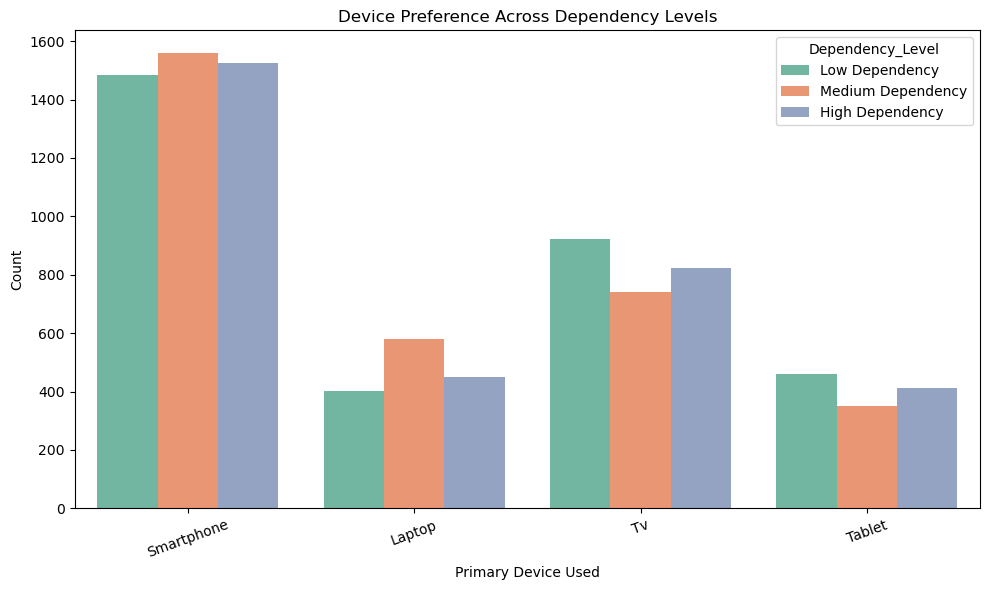

In [11]:
# Habit Pattern: Device Preference by Dependency Level

fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Primary_Device', hue='Dependency_Level', palette='Set2')
plt.title("Device Preference Across Dependency Levels")
plt.xlabel("Primary Device Used")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

C:\Users\geeky\AppData\Local\Temp\ipykernel_15828\287932309.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Urban_or_Rural', y='Dependency_Score', palette='coolwarm')


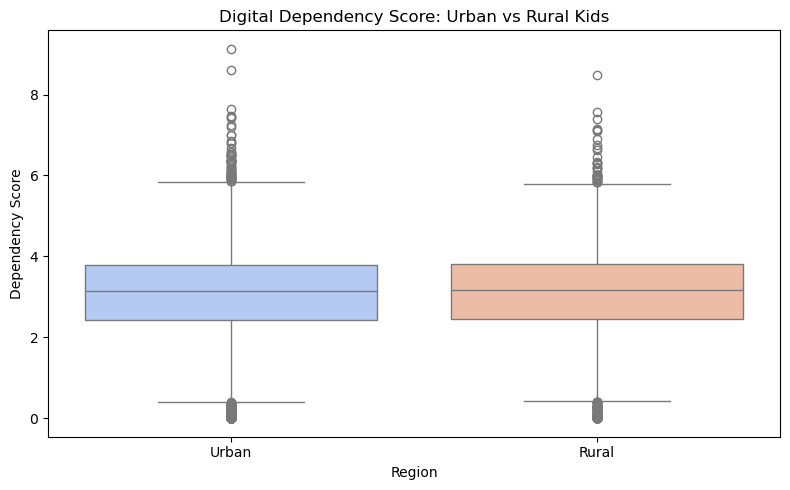

In [12]:
# Segment Insight: Urban vs Rural – Dependency Comparison

fig = plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Urban_or_Rural', y='Dependency_Score', palette='coolwarm')
plt.title("Digital Dependency Score: Urban vs Rural Kids")
plt.xlabel("Region")
plt.ylabel("Dependency Score")
plt.tight_layout()
plt.show()


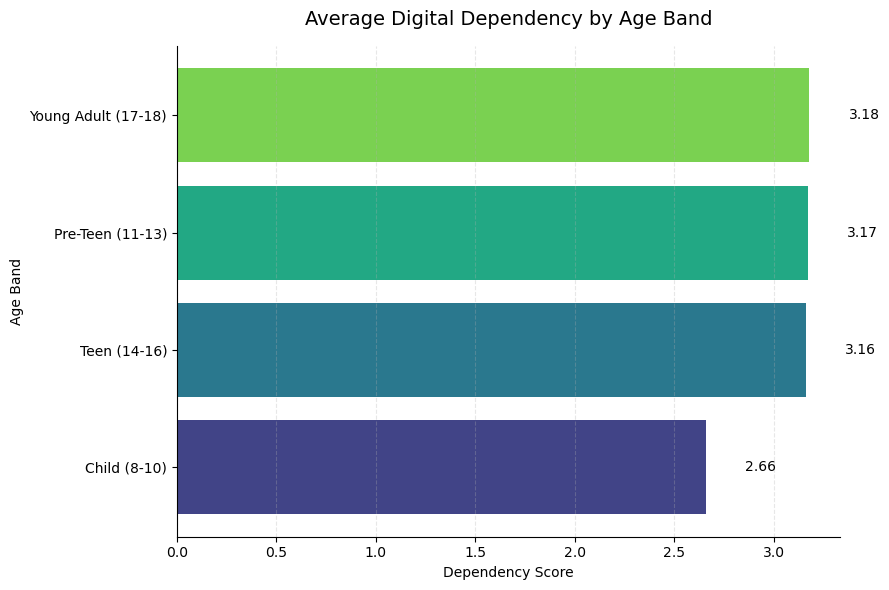

In [13]:
# Bar Chart: Average Digital Dependency by Age Band

age_dep = df.groupby('Age_Band')['Dependency_Score'].mean().reset_index()
age_dep = age_dep.sort_values('Dependency_Score')

colors = sns.color_palette("viridis", len(age_dep))

fig, ax = plt.subplots(figsize=(9,6))
bars = ax.barh(age_dep['Age_Band'], age_dep['Dependency_Score'], color=colors)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.2, bar.get_y() + bar.get_height()/2,
            f"{width:.2f}", va='center', fontsize=10)

ax.set_title("Average Digital Dependency by Age Band", fontsize=14, pad=15)
ax.set_xlabel("Dependency Score")
ax.set_ylabel("Age Band")
ax.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine()

plt.tight_layout()
plt.show()
